<a href="https://colab.research.google.com/github/Sheila-Otieno/Machine-learning/blob/main/Tensorflow_eng_to_swe_translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [ ]:
# function to read raw text file
def read_text(filename):
        # open the file
        file = open(filename, mode='rt', encoding='utf-8')
        
        # read all text
        text = file.read()
        file.close()
        return text

In [ ]:
# split a text into sentences
def to_lines(text):
      sents = text.strip().split('\n')
      sents = [i.split('\t') for i in sents]
      return sents

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving swe.txt to swe.txt


In [ ]:
data = read_text("swe.txt")
swe_eng = to_lines(data)
swe_eng = array(swe_eng)

In [ ]:
swe_eng = swe_eng[:50000,:]

In [ ]:
swe_eng

array([['Go.', 'Gå.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8955604 (mr_vile)'],
       ['Run!', 'Spring!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #2122575 (herrsilen)'],
       ['Who?', 'Vem?',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2083030 (CK) & #2122582 (herrsilen)'],
       ...,
       ["If you translate from your second language into your own native language, rather than the other way around, you're less likely to make mistakes.",
        'Om man översätter från sitt andraspråk till sitt modersmål, istället för omvänt, är det mindre sannolikhet för att man gör fel.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1230823 (CK) & #9016567 (morbrorper)'],
       ['The Tatoeba Project, which can be found online at tatoeba.org, is working on creating a large database of example sentences translated into many languages.',
        'Tatoebaprojektet, som återfinns online på tatoeba.org, går ut på att

In [ ]:
# Remove punctuation
swe_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in swe_eng[:,0]]
swe_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in swe_eng[:,1]]

swe_eng

array([['Go', 'Gå',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8955604 (mr_vile)'],
       ['Run', 'Spring',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #2122575 (herrsilen)'],
       ['Who', 'Vem',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2083030 (CK) & #2122582 (herrsilen)'],
       ...,
       ['If you translate from your second language into your own native language rather than the other way around youre less likely to make mistakes',
        'Om man översätter från sitt andraspråk till sitt modersmål istället för omvänt är det mindre sannolikhet för att man gör fel',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1230823 (CK) & #9016567 (morbrorper)'],
       ['The Tatoeba Project which can be found online at tatoebaorg is working on creating a large database of example sentences translated into many languages',
        'Tatoebaprojektet som återfinns online på tatoebaorg går ut på att skapa en stor datab

In [ ]:
# convert text to lowercase
for i in range(len(swe_eng)):
    swe_eng[i,0] = swe_eng[i,0].lower()
    swe_eng[i,1] = swe_eng[i,1].lower()

swe_eng

array([['go', 'gå',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8955604 (mr_vile)'],
       ['run', 'spring',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #2122575 (herrsilen)'],
       ['who', 'vem',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2083030 (CK) & #2122582 (herrsilen)'],
       ...,
       ['if you translate from your second language into your own native language rather than the other way around youre less likely to make mistakes',
        'om man översätter från sitt andraspråk till sitt modersmål istället för omvänt är det mindre sannolikhet för att man gör fel',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1230823 (CK) & #9016567 (morbrorper)'],
       ['the tatoeba project which can be found online at tatoebaorg is working on creating a large database of example sentences translated into many languages',
        'tatoebaprojektet som återfinns online på tatoebaorg går ut på att skapa en stor datab

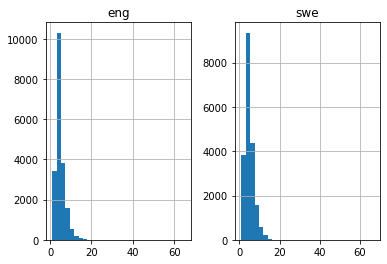

In [ ]:
#visualise the length of the sentences

# empty lists
eng_l = []
swe_l = []

# populate the lists with sentence lengths
for i in swe_eng[:,0]:
      eng_l.append(len(i.split()))

for i in swe_eng[:,1]:
      swe_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'swe':swe_l})

length_df.hist(bins = 30)
plt.show()

In [ ]:
# function to build a tokenizer
def tokenization(lines):
      tokenizer = Tokenizer()
      tokenizer.fit_on_texts(lines)
      return tokenizer

In [ ]:
# prepare english tokenizer
eng_tokenizer = tokenization(swe_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 18
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 5435


In [ ]:
# prepare swedish tokenizer
swe_tokenizer = tokenization(swe_eng[:, 1])
swe_vocab_size = len(swe_tokenizer.word_index) + 1

swe_length = 18
print('Swedish Vocabulary Size: %d' % swe_vocab_size)

Swedish Vocabulary Size: 7945


In [ ]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
         # integer encode sequences
         seq = tokenizer.texts_to_sequences(lines)
         # pad sequences with 0 values
         seq = pad_sequences(seq, maxlen=length, padding='post')
         return seq

In [ ]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(swe_eng, test_size=0.2, random_state = 12)

In [ ]:
# prepare training data
trainX = encode_sequences(swe_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(swe_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [ ]:
# build NMT model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
      model = Sequential()
      model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
      model.add(LSTM(units))
      model.add(RepeatVector(out_timesteps))
      model.add(LSTM(units, return_sequences=True))
      model.add(Dense(out_vocab, activation='softmax'))
      return model

In [ ]:
# model compilation
model = define_model(swe_vocab_size, eng_vocab_size, swe_length, eng_length, 512)

In [ ]:
import tensorflow as tf


In [ ]:
rms = tf.keras.optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
filename = 'model.h1.24_jan_19'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=30, batch_size=512, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose=1)

Epoch 1/30
26/26 [==============================] - ETA: 0s - loss: 2.9471
Epoch 1: val_loss improved from inf to 2.02226, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


26/26 [==============================] - 221s 8s/step - loss: 2.9471 - val_loss: 2.0223
Epoch 2/30
26/26 [==============================] - ETA: 0s - loss: 1.9592
Epoch 2: val_loss improved from 2.02226 to 1.98699, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


26/26 [==============================] - 217s 8s/step - loss: 1.9592 - val_loss: 1.9870
Epoch 3/30
26/26 [==============================] - ETA: 0s - loss: 1.8791
Epoch 3: val_loss improved from 1.98699 to 1.89401, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


26/26 [==============================] - 216s 8s/step - loss: 1.8791 - val_loss: 1.8940
Epoch 4/30
26/26 [==============================] - ETA: 0s - loss: 1.8311
Epoch 4: val_loss improved from 1.89401 to 1.86721, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


26/26 [==============================] - 217s 8s/step - loss: 1.8311 - val_loss: 1.8672
Epoch 5/30
26/26 [==============================] - ETA: 0s - loss: 1.7881
Epoch 5: val_loss improved from 1.86721 to 1.85964, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


26/26 [==============================] - 218s 8s/step - loss: 1.7881 - val_loss: 1.8596
Epoch 6/30
26/26 [==============================] - ETA: 0s - loss: 1.7585
Epoch 6: val_loss improved from 1.85964 to 1.85846, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


26/26 [==============================] - 217s 8s/step - loss: 1.7585 - val_loss: 1.8585
Epoch 7/30
26/26 [==============================] - ETA: 0s - loss: 1.7315
Epoch 7: val_loss improved from 1.85846 to 1.79664, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


26/26 [==============================] - 219s 8s/step - loss: 1.7315 - val_loss: 1.7966
Epoch 8/30
26/26 [==============================] - ETA: 0s - loss: 1.7010
Epoch 8: val_loss did not improve from 1.79664
26/26 [==============================] - 202s 8s/step - loss: 1.7010 - val_loss: 1.8799
Epoch 9/30
26/26 [==============================] - ETA: 0s - loss: 1.6759
Epoch 9: val_loss improved from 1.79664 to 1.75243, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


26/26 [==============================] - 215s 8s/step - loss: 1.6759 - val_loss: 1.7524
Epoch 10/30
26/26 [==============================] - ETA: 0s - loss: 1.6417
Epoch 10: val_loss did not improve from 1.75243
26/26 [==============================] - 199s 8s/step - loss: 1.6417 - val_loss: 1.7622
Epoch 11/30
26/26 [==============================] - ETA: 0s - loss: 1.6065
Epoch 11: val_loss improved from 1.75243 to 1.73560, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


26/26 [==============================] - 216s 8s/step - loss: 1.6065 - val_loss: 1.7356
Epoch 12/30
26/26 [==============================] - ETA: 0s - loss: 1.5797
Epoch 12: val_loss improved from 1.73560 to 1.71932, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


26/26 [==============================] - 214s 8s/step - loss: 1.5797 - val_loss: 1.7193
Epoch 13/30
26/26 [==============================] - ETA: 0s - loss: 1.5415
Epoch 13: val_loss improved from 1.71932 to 1.69280, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


26/26 [==============================] - 215s 8s/step - loss: 1.5415 - val_loss: 1.6928
Epoch 14/30
26/26 [==============================] - ETA: 0s - loss: 1.5090
Epoch 14: val_loss improved from 1.69280 to 1.66695, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


26/26 [==============================] - 215s 8s/step - loss: 1.5090 - val_loss: 1.6669
Epoch 15/30
26/26 [==============================] - ETA: 0s - loss: 1.4734
Epoch 15: val_loss did not improve from 1.66695
26/26 [==============================] - 199s 8s/step - loss: 1.4734 - val_loss: 1.6731
Epoch 16/30
26/26 [==============================] - ETA: 0s - loss: 1.4382
Epoch 16: val_loss improved from 1.66695 to 1.65801, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


26/26 [==============================] - 215s 8s/step - loss: 1.4382 - val_loss: 1.6580
Epoch 17/30
26/26 [==============================] - ETA: 0s - loss: 1.4050
Epoch 17: val_loss improved from 1.65801 to 1.62890, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


26/26 [==============================] - 214s 8s/step - loss: 1.4050 - val_loss: 1.6289
Epoch 18/30
26/26 [==============================] - ETA: 0s - loss: 1.3710
Epoch 18: val_loss improved from 1.62890 to 1.61663, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


26/26 [==============================] - 219s 8s/step - loss: 1.3710 - val_loss: 1.6166
Epoch 19/30
26/26 [==============================] - ETA: 0s - loss: 1.3389
Epoch 19: val_loss improved from 1.61663 to 1.60357, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


26/26 [==============================] - 217s 8s/step - loss: 1.3389 - val_loss: 1.6036
Epoch 20/30
26/26 [==============================] - ETA: 0s - loss: 1.3093
Epoch 20: val_loss improved from 1.60357 to 1.59124, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


26/26 [==============================] - 217s 8s/step - loss: 1.3093 - val_loss: 1.5912
Epoch 21/30
26/26 [==============================] - ETA: 0s - loss: 1.2754
Epoch 21: val_loss improved from 1.59124 to 1.57434, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


26/26 [==============================] - 218s 8s/step - loss: 1.2754 - val_loss: 1.5743
Epoch 22/30
26/26 [==============================] - ETA: 0s - loss: 1.2519
Epoch 22: val_loss improved from 1.57434 to 1.55886, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


26/26 [==============================] - 219s 8s/step - loss: 1.2519 - val_loss: 1.5589
Epoch 23/30
26/26 [==============================] - ETA: 0s - loss: 1.2139
Epoch 23: val_loss did not improve from 1.55886
26/26 [==============================] - 202s 8s/step - loss: 1.2139 - val_loss: 1.5896
Epoch 24/30
26/26 [==============================] - ETA: 0s - loss: 1.1896
Epoch 24: val_loss improved from 1.55886 to 1.54688, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


26/26 [==============================] - 217s 8s/step - loss: 1.1896 - val_loss: 1.5469
Epoch 25/30
26/26 [==============================] - ETA: 0s - loss: 1.1605
Epoch 25: val_loss did not improve from 1.54688
26/26 [==============================] - 202s 8s/step - loss: 1.1605 - val_loss: 1.5558
Epoch 26/30
26/26 [==============================] - ETA: 0s - loss: 1.1327
Epoch 26: val_loss improved from 1.54688 to 1.52043, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


26/26 [==============================] - 217s 8s/step - loss: 1.1327 - val_loss: 1.5204
Epoch 27/30
26/26 [==============================] - ETA: 0s - loss: 1.1032
Epoch 27: val_loss did not improve from 1.52043
26/26 [==============================] - 201s 8s/step - loss: 1.1032 - val_loss: 1.5793
Epoch 28/30
26/26 [==============================] - ETA: 0s - loss: 1.0811
Epoch 28: val_loss improved from 1.52043 to 1.50849, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


26/26 [==============================] - 218s 8s/step - loss: 1.0811 - val_loss: 1.5085
Epoch 29/30
26/26 [==============================] - ETA: 0s - loss: 1.0525
Epoch 29: val_loss improved from 1.50849 to 1.50799, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


26/26 [==============================] - 218s 8s/step - loss: 1.0525 - val_loss: 1.5080
Epoch 30/30
26/26 [==============================] - ETA: 0s - loss: 1.0241
Epoch 30: val_loss did not improve from 1.50799
26/26 [==============================] - 201s 8s/step - loss: 1.0241 - val_loss: 1.5103


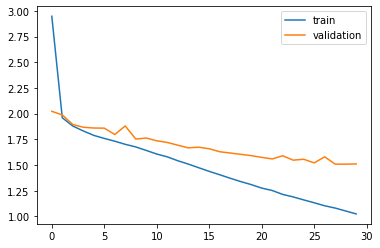

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()


In [ ]:
import numpy as np 

model = load_model('model.h1.24_jan_19')

preds = model.predict(testX.reshape((testX.shape[0],testX.shape[1])))


In [ ]:
def get_word(n, tokenizer):
      for word, index in tokenizer.word_index.items():
          if index == n:
              return word
      return None

In [ ]:
preds_text = []
for i in preds:
       temp = []
       for j in range(len(i)):
            t = get_word(i[j], eng_tokenizer)
            if j > 0:
                if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                     temp.append('')
                else:
                     temp.append(t)
            else:
                   if(t == None):
                          temp.append('')
                   else:
                          temp.append(t) 

       preds_text.append(' '.join(temp))
